In [15]:
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [16]:
### load trained model
model_path = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/trained_models/hog_models_128_64/hogsvm_pedes_9bins.npy'
model_path = 'hogsvm_nucleus_9bins_pickle_proto_2.npy'
model_path = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/trained_models/hog_models_128_64/hogsvm_pedes_9bins_3780_feat.npy'
model_path = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/trained_models/hog_models_128_64/hogsvm_pedes_9bins_756_feat.npy'
#model_path ='/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/hogsvm_pedes_9bins.npy'
#model_path  = 'hogsvm_pedes_3bins.npy'
model = joblib.load(model_path)
print(model)

LinearSVC(max_iter=5000)


In [17]:
import skimage
import sklearn
print(skimage.__version__)
print(sklearn.__version__)

#if (sklearn.__version__ != 0.24.1):
#   python3 -m pip install -U scikit-image==0.24.1

0.17.2
0.23.2


In [18]:
# define the sliding window:
def sliding_window(image, stepSize, windowSize):
    #print(image.shape)
    #print(windowSize)
    for y in range(0, image.shape[0], stepSize[0]):
        for x in range(0, image.shape[1], stepSize[1]):
            # yield the current window
            #print(x,y, image[y: y + windowSize[1], x:x + windowSize[0]].shape)
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [19]:


def get_detection_boxes_image_pyramid(image, downscale, window_size, stride_slide_win, scale=0, layers = 4, CS_th = 0.2, image_start = [0,0]):
    [winH, winW] = window_size
    count_hog = 0
    detections = []
    hog_count_cum = 0
    #print(window_size, [winH, winW])
    for resized in pyramid_gaussian(image, downscale=downscale, max_layer = layers): 
        #print('resized shape:', resized.shape)
        for (x,y,window) in sliding_window(resized, stepSize=stride_slide_win, windowSize=window_size):
            count_hog += 1
            #print(x,y,window.shape)
            if window.shape[0] != winW or window.shape[1] !=winH: # ensure the sliding window has met
                #print('here')
                continue

            #st_time = time.time()
            fds = hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2')
            #print('here too')
            #print(time.time()-st_time)

            fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
            pred = model.predict(fds) 
            #print('scale = ', scale)
            if pred == 1:
                if model.decision_function(fds) > CS_th:
                    #print('detected at sclae:' , scale)
                    #print(int(x * (downscale**scale)), int(y * (downscale**scale)))
                    #print("Detection:: Location -> ({}, {})".format(x, y))
                    #print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                    detections.append((int(x * (downscale**scale))+image_start[0], int(y * (downscale**scale))+image_start[1], model.decision_function(fds),
                                    int(window_size[0]*(downscale**scale)), # create a list of all the predictions found
                                        int(window_size[1]*(downscale**scale)), scale))
                    #return detections

        scale+=1
        hog_count_cum += count_hog
        #print('hog count:', count_hog)
        count_hog = 0
        #print('cale:', scale)
    return detections, hog_count_cum


In [20]:
orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)
threshold = .5
stride_slide_win = [32,32]
windowSize = [128,64]
downscale = 1.2
detections = []
scale = 0
max_layers = 0

([(128, 0, array([1.51002938]), 128, 64, 0), (256, 0, array([1.16868647]), 128, 64, 0), (288, 0, array([1.81499012]), 128, 64, 0), (416, 0, array([0.63065766]), 128, 64, 0), (448, 0, array([1.180246]), 128, 64, 0), (736, 0, array([2.43661021]), 128, 64, 0), (768, 0, array([0.45045585]), 128, 64, 0), (896, 0, array([0.45077581]), 128, 64, 0), (1152, 0, array([1.1170778]), 128, 64, 0), (1184, 0, array([1.54052496]), 128, 64, 0), (1216, 0, array([0.71726421]), 128, 64, 0), (1344, 0, array([1.11856505]), 128, 64, 0), (32, 32, array([0.45278624]), 128, 64, 0), (352, 32, array([0.51224753]), 128, 64, 0), (512, 32, array([1.11706508]), 128, 64, 0), (768, 32, array([0.3593175]), 128, 64, 0), (832, 32, array([0.72750755]), 128, 64, 0), (1152, 32, array([1.20908282]), 128, 64, 0), (1184, 32, array([0.41326648]), 128, 64, 0), (64, 64, array([0.31824099]), 128, 64, 0), (160, 64, array([0.81673091]), 128, 64, 0), (352, 64, array([0.97728779]), 128, 64, 0), (864, 64, array([0.4263661]), 128, 64, 0),

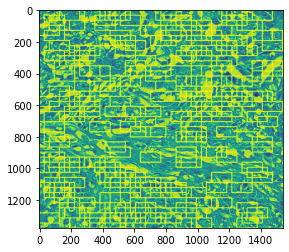

True

In [21]:
#### check gaussian pyramis images ##
from matplotlib import pyplot as plt
%matplotlib inline
import cv2 
import time

inp_img_path = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/5.jpg'
inp_img_path = '/media/dtu-project2/2GB_HDD/classifymito/mitosis_detection/Data_v3/Data/Images/nucleus/A03_00Aa.jpg'
img_folder = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/output_folder_temp/input'
count = 0
st = time.time()
'''
for img in os.listdir(img_folder):
    count += 1
    img_path = os.path.join(img_folder, img)
    #print(img_path)
    image = cv2.imread(img_path, flags=0)
    [w,h] = image.shape
    image = cv2.resize(image, (h//2,w//2))
    st = time.time()
    detections = get_detection_boxes_image_pyramid(image, downscale=downscale, \
                                                   stride_slide_win= stride_slide_win, window_size=windowSize, layers = max_layers,CS_th=0.1)
    print(detections)
    print('dur: ', time.time()-st
    


    )
#print(detections)
print('pass time: ', (time.time()-st)/count)
#print(count)
print('number of detections:', len(detections))
print(detections[0][0][0])
print(detections[0][1])

if detections != []:
    image = cv2.rectangle(image, (detections[0][0][0],detections[0][0][1]), (detections[0][0][0]+detections[0][0][3], detections[0][0][1]+detections[0][0][4]), (255,225,0), 1)
    plt.imshow(image)
    plt.show()
'''
'''
for resized_imgs in pyramid_gaussian(img, downscale=1.5, max_layer=4):
    print(resized_imgs.shape, i)
    plt.figure()
    plt.imshow(resized_imgs, cmap='gray')
    plt.show()
    i += 1

    '''


## test

st = time.time()
image = cv2.imread(inp_img_path, flags=0)
img_org = image.copy()
[w,h] = image.shape

# smooth the image
kernel = np.ones((10,10), np.float32)/100
image = cv2.filter2D(image, -1, kernel)


#image = cv2.resize(image, (h//2,w//2))
st = time.time()
detections = get_detection_boxes_image_pyramid(image, downscale=downscale, \
                                                   stride_slide_win= stride_slide_win, window_size=windowSize, layers = max_layers,CS_th=0.3)
print(detections)

print('dur: ', time.time()-st)


if detections != []:
    for i in range(len(detections[0])):
        image = cv2.rectangle(img_org, (detections[0][i][0],detections[0][i][1]), (detections[0][i][0]+detections[0][i][3], detections[0][i][1]+detections[0][i][4]), (255,225,255), 5)
    plt.imshow(img_org)
    plt.show()
cv2.imwrite('hhhh.jpg', img_org)

In [8]:
len(detections[0])

33

(720, 1280, 3)


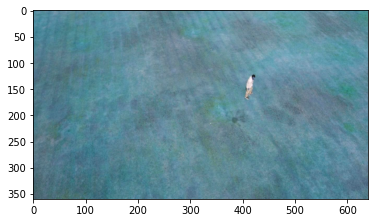

detection time:  0.36292147636413574


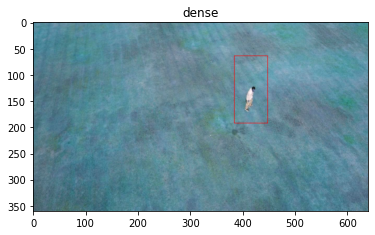

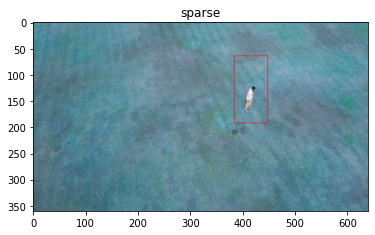

In [31]:


orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)
threshold = .3
stride_slide_win = [64,32]
#stride_slide_win = [10,10]
stride_slide_win_dense = [10,10]
windowSize = [64,128]
downscale = 1.5
detections = []
scale = 0
max_layers = 4
cs_thresh_sparse = 0.02
cs_thresh_dense = 0.3


def sparse_detect(img, sparse_slide_wind):
    #detections = []
    #[w,h] = img.shape
    #st = time.time()
    detections,hog_count = get_detection_boxes_image_pyramid(img, downscale=downscale, stride_slide_win= sparse_slide_wind, window_size=windowSize, layers = max_layers,\
                                                  CS_th = cs_thresh_sparse)
    #print(stride_slide_win)
    return detections, hog_count



def dense_detect(orig_image, detections):
    dense_detections = []
    total_dense_hog_c = 0
    for item in detections:
        #print(item)
        image = orig_image[item[1]:item[1]+item[4], item[0]:item[0]+item[3]]
        #print(image.shape)
        #plt.figure()
        ##plt.imshow(image)
        #plt.show()
        detections,hog_count = get_detection_boxes_image_pyramid(image, downscale=1.1, stride_slide_win= stride_slide_win_dense, window_size=windowSize, layers = 0,\
                                                       CS_th =cs_thresh_dense, image_start = [item[0],item[1]])
        #
        dense_detections = dense_detections+detections
        total_dense_hog_c += hog_count
        #print(item, dense_detections)
    return dense_detections, total_dense_hog_c
    
    
input_img_path = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/5.jpg'

img = cv2.imread(input_img_path, flags =1)
print(img.shape)
img = cv2.resize(img, (640,360))

#cv2.imwrite('original dtb70.jpg', img)

plt.figure()
plt.imshow(img)
plt.show()

################# # sparse detections###########
st = time.time()
detecti, hog_count_sparse = sparse_detect(img, sparse_slide_wind=stride_slide_win)

#print('sfs',detecti)
#### image plot stage 1 ###
#img2 = img.copy()

#dense_detect(image, detecti)


################ DENSE DETECTIOS ###########
#print('..................dense ............\n')
dense_detections, hog_count_dense = dense_detect(img, detecti)
print('detection time: ', (time.time()-st))


#print(dense_detections)
#print(hog_count_sparse, hog_count_dense)



##### plot rects in original Image ######

img2 = img.copy()
img3 = img.copy()
for item in dense_detections:
    img2 = cv2.rectangle(img2, (item[0],item[1]), (item[0]+item[3], item[1]+item[4]), (255,0,0), 1)
    #cv2.imwrite('okutama dense out.jpg', img2)
    
for item in detecti:
    img3 = cv2.rectangle(img3, (item[0],item[1]), (item[0]+item[3], item[1]+item[4]), (255,0,0), 1)
    #cv2.imwrite('okutama sparse out.jpg', img3)
plt.figure()
plt.imshow(img2)
plt.title('dense')

plt.figure()
plt.imshow(img3)
plt.title('sparse')


plt.show()



1
(720, 1280, 3)


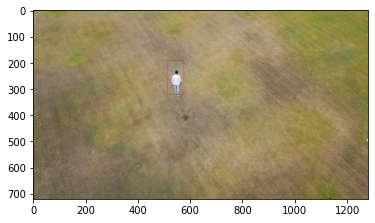

final detect:   (512, 192, array([1.50391351]), 64, 128, 0)
0.4
0.26666666666666666
[0.415625, 0.3013888888888889, 0, 1.5039135057100927]

2
(720, 1280, 3)


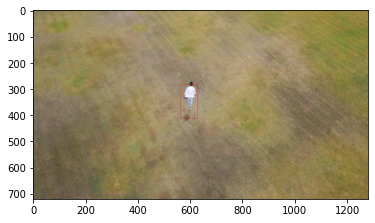

final detect:   (564, 284, array([3.83110156]), 64, 128, 0)
0.440625
0.39444444444444443
[0.45625, 0.42916666666666664, 0, 3.8311015642423873]

3
(720, 1280, 3)


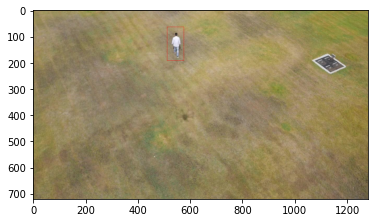

final detect:   (512, 64, array([1.71071229]), 64, 128, 0)
0.4
0.08888888888888889
[0.415625, 0.12361111111111112, 0, 1.7107122883523074]

4
(720, 1280, 3)


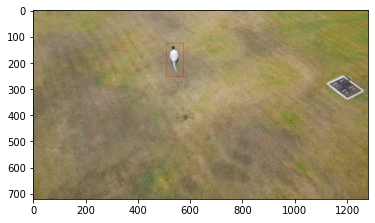

final detect:   (510, 126, array([3.06424293]), 64, 128, 0)
0.3984375
0.175
[0.4140625, 0.20972222222222223, 0, 3.0642429291575772]

5
(360, 640, 3)


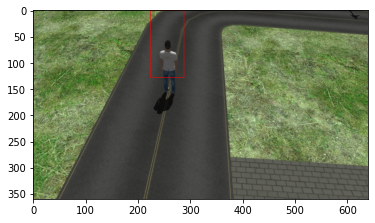

final detect:   (224, 0, array([2.38788393]), 64, 128, 0)
0.35
0.0
[0.38125, 0.06944444444444445, 0, 2.387883926425876]

6
(360, 640, 3)


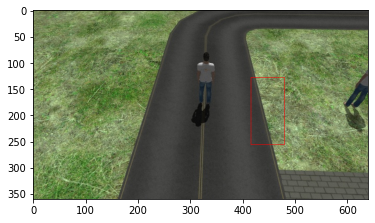

final detect:   (416, 128, array([1.30454295]), 64, 128, 0)
0.65
0.35555555555555557
[0.68125, 0.425, 0, 1.304542950058945]

7
(360, 640, 3)


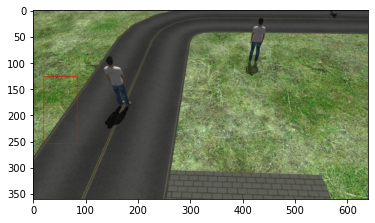

final detect:   (20, 126, array([2.85813669]), 64, 128, 0)
0.03125
0.35
[0.0625, 0.41944444444444445, 0, 2.858136686429045]

8
(360, 640, 3)


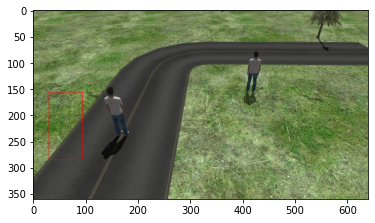

final detect:   (30, 156, array([1.44229598]), 64, 128, 0)
0.046875
0.43333333333333335
[0.078125, 0.5027777777777778, 0, 1.4422959762402612]

9
(360, 640, 3)


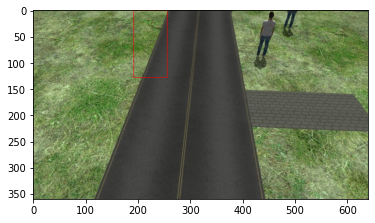

final detect:   (192, 0, array([2.16755534]), 64, 128, 0)
0.3
0.0
[0.33125, 0.06944444444444445, 0, 2.1675553442036772]

10
(360, 640, 3)


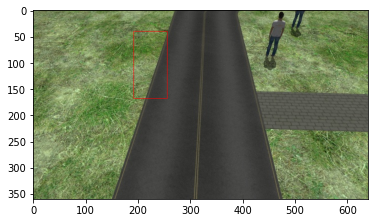

final detect:   (192, 40, array([2.61772607]), 64, 128, 0)
0.3
0.1111111111111111
[0.33125, 0.18055555555555555, 0, 2.617726072854089]

11
(360, 640, 3)


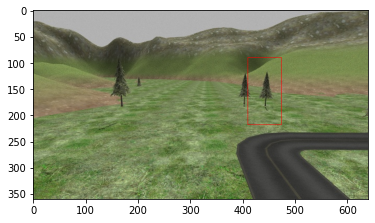

final detect:   (410, 90, array([1.71891147]), 64, 128, 0)
0.640625
0.25
[0.671875, 0.3194444444444444, 0, 1.7189114693165366]

12
(360, 640, 3)


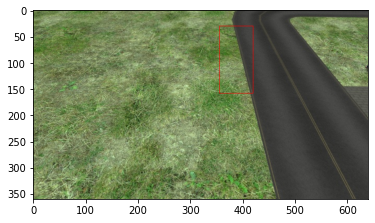

final detect:   (356, 30, array([1.60178674]), 64, 128, 0)
0.55625
0.08333333333333333
[0.5875, 0.1527777777777778, 0, 1.6017867424860204]

13
(360, 640, 3)


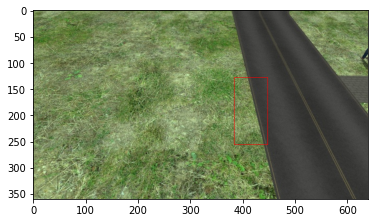

final detect:   (384, 128, array([1.32869332]), 64, 128, 0)
0.6
0.35555555555555557
[0.63125, 0.425, 0, 1.3286933244935017]


average time: 1.384307311131404
total imagesL:  13
1620.3076923076924


In [35]:

%matplotlib inline
import time
import os
import cv2 

person = 'person7'

test_img_folder = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/output_folder_temp/input' 
test_img_folder = "/home/dtu-project2/catkin_ws/src/image_processor/image_database/gazebo_pedestrian_test"
#annotation_file = '/media/dtu-project2/2GB_HDD/object tracker/kalman/annotations/'+person+'.txt'
save_folder = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/output_folder_temp/output'
detection_box_text_file_dir = '/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/detection_outputs/detected_bbox_text_files'

orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)
threshold = .3
sparse_slide_win = [64,32]
#stride_slide_win = [10,10]
stride_slide_win_dense = [10,10]
windowSize = [64,128]
downscale = 1.5
detections = []
scale = 0
max_layers = 4
cs_thresh_sparse = 0.5
cs_thresh_dense = 1.1


count = 0
hog_count_tot =0
st = time.time()
dur = 0.0

no_detection_count = 0

def Intersection_over_union(boxA, boxB):
    a = max(boxA[0], boxB[0])
    b = max(boxA[1], boxB[1])
    c = min(boxA[2], boxB[2])
    d = min(boxA[3], boxB[3])

    intersect_w = max(0, c-a+1)
    intersect_h = max(0, d-b+1)
    
    intersect_area = intersect_w*intersect_h
    union_area = (boxA[2]-boxA[0]+1)*(boxA[3]-boxA[1]+1) + \
                 (boxB[2]-boxB[0]+1)*(boxB[3]-boxB[1]+1) - intersect_area
    iou = intersect_area/union_area
    return iou

def update_bbox(dense_detections, index):
    print('h')
    

def iou_thresholding(dense_bbox, iou_th=0.5):
    #print('.............', dense_bbox)
    to_remove_index = []
    for i in range(len(dense_bbox)):
        for j in range(i+1,len(dense_bbox)):
            boxA = [dense_bbox[i][0], dense_bbox[i][1], dense_bbox[i][0]+64, dense_bbox[i][1]+128]
            boxB = [dense_bbox[j][0], dense_bbox[j][1], dense_bbox[j][0]+64, dense_bbox[j][1]+128]
            #print(boxA, boxB)
            #print(Intersection_over_union(boxA, boxB))
            #print(dense_bbox[j][2][0])
            #print('i: ', i, 'j: ', j )
            if Intersection_over_union(boxA, boxB)>=iou_th:
                if dense_bbox[i][2][0] >= dense_bbox[j][2][0]:
                    to_remove_index.append(j)
                    #dense_bbox.pop(j)
                    #print(dense_bbox,'.......')
                    #j = j-1
                else:
                    #dense_bbox.pop(i)
                    to_remove_index.append(i)
                    #print(dense_bbox,'..........')
                    #j = j-1
            #print('i: ', i, 'j: ', j )
    
    unique_list = list(set(to_remove_index))
    #final_id = [x for x in a if x not in b]
    ll = []
    for i in range(len(dense_bbox)):
        ll.append(i)
    for item in unique_list:
        if item in ll:
            ll.remove(item)
    #print("ll: ",ll)

    #print('to remove index: ', unique_list)
    
    return dense_bbox[ll[0]]

#def centre_error(pred_cen, gt_cen):
    
prediction_file = os.path.join(detection_box_text_file_dir, person)
fh = open(prediction_file+'.txt', 'w')

file_list = sorted(os.listdir(test_img_folder))
for image in file_list:
    count += 1
    print(count)
    img = cv2.imread(os.path.join(test_img_folder, image), flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(img.shape)
    #img = cv2.resize(img, (img.shape[1]//2,img.shape[0]//2))
    [h, w, c] = img.shape
    print(img.shape)
    
    
    st2 = time.time()
    ############ sparse
    detecti, hog_count_sparse = sparse_detect(img, sparse_slide_wind=sparse_slide_win)
    ################# dense
    dense_detections, hog_count_dense = dense_detect(img, detecti)
    #############
    dur = dur+(time.time()-st2)
    

    ########### IOU thresholding ##############
    #print('sparse: ', detecti, '\n')
    #print('dense: ', dense_detections,'\n')
    
    hog_count_tot = hog_count_tot+hog_count_sparse+hog_count_dense

    # plot rects and save ####
    img2 = img.copy()
    
    for item in detecti:
        img2 = cv2.rectangle(img2, (item[0],item[1]), (item[0]+item[3], item[1]+item[4]), (255,0,0), 1)
    
    #save_path2 = os.path.join(save_folder, "sparse"+image)
    #cv2.imwrite(save_path2, img2)
    #plt.imshow( img2)
    
    img3 = img.copy()
    for item in dense_detections:
        img3 = cv2.rectangle(img3, (item[0],item[1]), (item[0]+item[3], item[1]+item[4]), (255,0,0), 1)  
        
    #save_path = os.path.join(save_folder, "dense"+image)
    #cv2.imwrite(save_path, img3)
    #plt.figure()
    #plt.imshow(img3)
    
    if len(dense_detections) != 0:
        final_detection  = iou_thresholding(dense_detections, 0.5)
        img4 = img.copy()
        img4 = cv2.rectangle(img4, (final_detection[0],final_detection[1]), \
                             (final_detection[0]+final_detection[3], \
                              final_detection[1]+final_detection[4]), (255,0,0), 1)
        plt.figure()
        plt.imshow(img4)
        plt.show()
        print("final detect:  ", final_detection)
        print(final_detection[0]/w)
        print(final_detection[1]/h)
        
        ss = '['+str((final_detection[0]+20)/w)+ ', ' +str((final_detection[1]+25)/h)+ ', '+ \
                 str(final_detection[5])+', '+ str(final_detection[2][0]) +']'+'\n'
        fh.write(ss)
        print(ss)
    else:
        print('no detection')
        no_detection_count += 1
        fh.write('['+'NaN, NaN, NaN, NaN'+']'+'\n')
    
fh.close()
#cv2.imshow()
print('\naverage time:', dur/count)
print('total imagesL: ', count)
print(hog_count_tot/count)
    